# Overall Flow

There are several parsing steps that just put data into objects
1. Parse the PSM files and get out Organism and Protein objects (currently done with .txt. goal to get .mzIdentML)
2. KEGG mapping
3. Run the Fisher's Exact test on all organisms and all pathways



## Step 1. Parse PSM files
At the end of this, we have a 'Parser.OrganismObjectsDictionary' variable that holds all the proteins and peptides found in an organism. The peptides are in the Protein object inside a dictionary keyed on their sequence

In [1]:
import IdentifyingPeptidesAndProteins
Acetylation = IdentifyingPeptidesAndProteins.ParserClass()
#parameters
DirectoryOfPSMs = "PSM.Results/Acetylation.DataPackage.1541"
#DirectoryOfPSMs = "PSM.Results/test"
FileToOrganismAssociation = "PSM.Results/PSMFilesAssociatedByOrganism_new.txt"
Acetylation.AddFiles(DirectoryOfPSMs, FileToOrganismAssociation)
Acetylation.SetQvalue(0.0001)
Acetylation.Main()

I got this path PSM.Results/PSMFilesAssociatedByOrganism_new.txt
The associations file listed 217 psm results files from 48 organisms


## Step 2 Parse the KEGG stuff
This leaves us with two things. a ProteinAccessionToKO dictionary and a KOsInAPathway dictionary. With these we should be able to get what we need in terms of which proteins are assigned to which pathways

In [2]:
import ParsingKeggFiles
K_Parser = ParsingKeggFiles.CreatorClass()
#parameters
DirectoryOfGhostKoalaAnnotations = "GhostKoalaAnnotation"
#DirectoryOfGhostKoalaAnnotations = "test_delme2"
PathwayMappingFilePath = "ko_pathway.list"
KoalaFileToOrganismAssociation = "GhostKoalaFilesAssociatedByOrganism.txt"
K_Parser.AddFiles(DirectoryOfGhostKoalaAnnotations, PathwayMappingFilePath)
K_Parser.Main()

## Step 3. Run the Fishers test for enrichment

Go through all the organisms and create the numbers necessary for a fisher's test


In [3]:
##some nice Methods that I'll put in it's own box
import scipy.stats as stats

def intersect(a, b):
    return list(set(a) & set(b))

def ComputeFishersExact(ModProteins, NotModProteins, PathwayProteins):
    ## this takes in three lists of proteins and computes the Fisher's exact test for 
    ##enrichment of PathwayProteins && ModProtein. It uses these variables
    #  x = IN_pathway && Modified = union of M and P
    #  M-x = NOT_IN_pathway && Modified
    #  P-x = IN_pathway && Not_Modified
    #  N-(P-x) = NOT_IN_pathway && Not_Modified

    Intersection = intersect(ModProteins, PathwayProteins)
    num_X = len(Intersection)
    num_P = len(PathwayProteins)
    num_N = len(NotModProteins)
    num_M = len(ModProteins)
    #Put them into the quartiles for the 2x2 square
    Q1 = num_X
    Q2 = num_M - num_X
    Q3 = num_P - num_X
    Q4 = num_N-(num_P-num_X)
    #print(num_X, num_M, num_N, num_P)
    oddsratio, pvalue = stats.fisher_exact([[Q1,Q2], [Q3,Q4]], alternative="greater")
    #
    return pvalue

def CorrectPValueBonferroni(pvalue, n_trials):
    correctedPValue = pvalue * n_trials
    if correctedPValue > 1:
        correctedPValue = 1.0
    return correctedPValue

def CorrectPValueBenjaminiHochberg(pvalue):
    #stuff here
    return "NOT FINISHED"
    

In [4]:
#NEW ONE
import Enrichment # has an object with simple functionality to hold the enrichment values

PathwayEnrichmentScores = {} # key = pathway, value = PathwayEnrichmentObject
n_trials = len(K_Parser.KOsInAPathway) # for each organism, I will be testing the enrichment for n pathways

for OrganismName in Acetylation.OrganismObjectsDictionary:
    #if not OrganismName == "Paenibacillus polymyxa ATCC842":
    #    #just for sanity in debugging
    #    continue
    OrganismObject = Acetylation.OrganismObjectsDictionary[OrganismName]
    ModifiedProteinListAsAccessions = OrganismObject.GetModifiedProteinList()
    ModifiedProteinListAsKO = K_Parser.ConvertListOfAccessionsToKOs(ModifiedProteinListAsAccessions)
    NotModifiedProteinListAsAccessions = OrganismObject.GetNotModifiedProteins()
    NotModifiedProteinListAsKO = K_Parser.ConvertListOfAccessionsToKOs(NotModifiedProteinListAsAccessions)
    ObservedProteinsAsAccessions = OrganismObject.Proteins.keys() #get all observed proteins
    ObservedProteinsAsKO = K_Parser.ConvertListOfAccessionsToKOs(ObservedProteinsAsAccessions)
    
    ###now we are looking at the number of proteins both as accessions and as KOs
    #print (OrganismName)
    #print ("Proteins with Mods: %s total, %s in KO"%(len(ModifiedProteinListAsAccessions), len(ModifiedProteinListAsKO)))
    #print ("Proteins NO Mods: %s total, %s in KO"%(len(NotModifiedProteinListAsAccessions), len(NotModifiedProteinListAsKO)))
    
    #now we test this list of protiens against the KEGG pathways for enrichment using a Fisher's Exact Test
    for Pathway in K_Parser.KOsInAPathway:
        if not Pathway in PathwayEnrichmentScores:
            Description = K_Parser.PathwayDescriptions[Pathway]
            PathwayEnrichmentScores[Pathway] = Enrichment.PathwayEnrichment(Pathway, Description)
        
        KOsInPathway = K_Parser.KOsInAPathway[Pathway]
        #it's necessary to limit the list of KO identifiers in a specific pathway
        #to only those that are observed in mass spectrometry data, otherwise
        #we can end up with a negative number in Q4.
        ObservedKOsInPathway = intersect(ObservedProteinsAsKO, KOsInPathway)
        pvalue = ComputeFishersExact(ModifiedProteinListAsKO, NotModifiedProteinListAsKO, ObservedKOsInPathway)
        PathwayEnrichmentScores[Pathway].AddValue(OrganismName, pvalue)


## Step 4. Making Pictures
Now I'm going through and trying to make images for the various pathways and PTMs

In [5]:
## now that I've computed all the enrichment scores, I will go through and see if any pathways
## are frequently significant across multiple organisms.

def GetDataForPlotting(EnrichmentDictionary, PvalueCutoff, AddThesePathways):
    ### EnrichmentDictionary = Dictionary of [pathway] -> Enrichment.PathwayEnrichment objects
    ### PvalueCutoff = <float>
    ### AddThesePathways = [list, of, specific, pathways] #as the PathwayID, key to EnrichmentDictionary above
    ListOfGoodPathways = [] # keep track for the second pass
    DataForBoxPlot = [] #going to be a multidimensional array, appended over time
    for Pathway in EnrichmentDictionary: # this loops through the keys, which is the name of the pathways
        MedianValue = EnrichmentDictionary[Pathway].GetMedian()
        if MedianValue < PvalueCutoff:
            ListOfGoodPathways.append(Pathway)

    #now we've cycled through all the pathways. Let's get working on that data structure for our boxplot
    PlotLabels = []
    for Pathway in ListOfGoodPathways:
        DataForBoxPlot.append(EnrichmentDictionary[Pathway].GetEnrichmentList())
        PlotLabels.append(EnrichmentDictionary[Pathway].PathwayDescription)
        
    for Pathway in AddThesePathways:
        DataForBoxPlot.append(EnrichmentDictionary[Pathway].GetEnrichmentList())
        PlotLabels.append(EnrichmentDictionary[Pathway].PathwayDescription)

    return(DataForBoxPlot, PlotLabels)

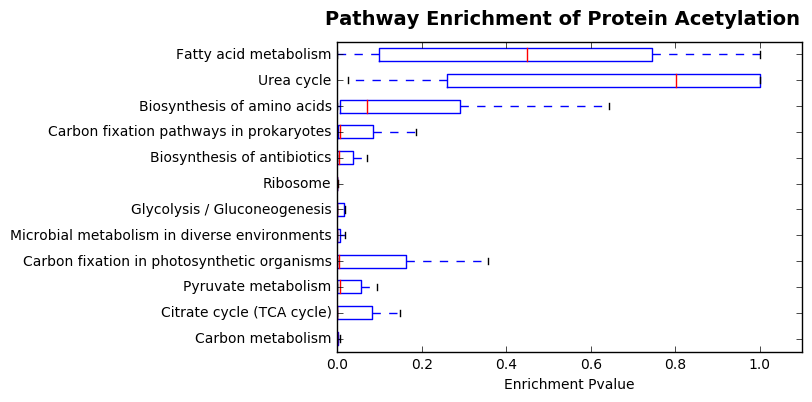

In [6]:
import matplotlib.pyplot as plt   
fig = plt.figure()
fig.suptitle('Pathway Enrichment of Protein Acetylation', fontsize=14, fontweight='bold')

ax = fig.add_subplot(111)
ax.set_xlabel('Enrichment Pvalue')

plt.xlim([0,1.1]) # to get all the things exactly at 1.0

########  adding some specific pathways for comparison in Acetylation
#map00220, Arginine biosynthesis - for the urea cycle cited prominently in http://science.sciencemag.org/content/327/5968/1000.full
#however just to be perfectly sure, I made my own KO listing and called it shp00001
#this custom pathway includes only the proteins listed in figure 1F of the science paper.
#map01212, Fatty acid metabolism, also in the science paper
#  map01230, Biosynthesis of amino acids
ListToAddForAcetylation = ['map01230', 'shp00001', 'map01212']
(Data, Labels) = GetDataForPlotting(PathwayEnrichmentScores, 0.01, ListToAddForAcetylation)

#I rather dislike the ability to assign a variable within a function call. It looks awful to me
#but apparently there are so many operaters that one can EITHER do by order or through assignment
#this is real herasy, and horrible coding. But that is the way that matplotlib (and R) works.
#until they FIX that, I'll be doing the  assignment route, because there is real potential 
# for confusion.  
#notch=0 ==> regualr boxes, not notched boxes
#sym='' ==> don't use any symbol to display outliers, could use 'rs' or 'b+' (works with showFliers)
#--- see http://matplotlib.org/api/axes_api.html for all the shorthand of what could be used
#vert=0 ==> a horizontal display, not vertical
plt.boxplot(Data, notch=0, showfliers=0, vert=0, labels=Labels)
plt.show()